<a href="https://colab.research.google.com/github/JayYe99/Cyber_Security/blob/main/%E2%80%9CGAN_Augmentation_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install pytorch-ignite

     |████████████████████████████████| 174kB 2.7MB/s 


### Import Library

In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from dataset import *
from models import *
from utils import *
from train import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, mIoU, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping, global_step_from_engine
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.param_scheduler import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

### Hyperparameters Declaration
Here declare the hyperparameters for GAN training scheme. 

In [ ]:
params = {
    # Data hyperparameters:
    "index": 2,
    "valid_size": 0.1,
    "window_size": 30,
    "max_rul": 130,
    "trim": True,

    # Model hyperparameters:
    "feature_size": 14,
    "noise_size": 63,
    "hidden_size": 128,
    "num_layers": 1,
    "dropout": 0.5,
    "bidirectional": True,

    # Training hypeparameters:
    "gamma": 1e-0,
    "max_epochs": 200,
    "batch_size": 128,
    "G_lr": 1e-3,
    "D_lr": 1e-3,
    "momentum": 0.5,
    "instance_noise": 0.1,
    "label_smooth": True,
    "label_flip": False
}

### Data Preprocessing


1.   Choose device to perform experiment.
2.   Load train and test dataset.
3.   Select only informative sensors.
4.   Normalize training data to range [-1, 1]. Statistics are calculated from training data and applied to both training and test dataset.
5.   Choose a subdataset from (FD001, FD002, FD003, FD004) for experiment (Set the "index" key in the **params** distionary). 
6.   Split the dataset into training and validation datasets.
7.   Prepare "Dataset" and "DataLoader" for training.



In [ ]:
# Setup device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset:
train_FD = [pd.read_csv(f"CMAPSS/train_FD00{i+1}.txt", sep=' ', header=None).iloc[:, :-2] for i in range(4)]
test_FD = [pd.read_csv(f"CMAPSS/test_FD00{i+1}.txt", sep=' ', header=None).iloc[:, :-2] for i in range(4)]
rul_FD = [pd.read_csv(f"CMAPSS/RUL_FD00{i+1}.txt", header=None) for i in range(4)]

# Select only informative sensors:
for i in range(4):
    train_FD[i] = train_FD[i].drop(columns=[2, 3, 4, 5, 9, 10, 14, 20, 22, 23])
    test_FD[i] = test_FD[i].drop(columns=[2, 3, 4, 5, 9, 10, 14, 20, 22, 23])

# Normalize FDs to [-1, 1] and RULs to [0, 1]:
FD_scalers = list()
for i in range(4):
    # Normalize FD:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_FD[i].iloc[:, 2:] = scaler.fit_transform(train_FD[i].iloc[:, 2:])
    test_FD[i].iloc[:, 2:] = scaler.transform(test_FD[i].iloc[:, 2:])
    FD_scalers.append(scaler)
    # Normalize RUL:
    ruls = get_all_rul(train_FD[i], params["max_rul"])
    train_FD[i]['rul'] = ruls  

# Choose dataset:
train_fd, val_fd = train_val_split([train_FD[params["index"]-1]], params["valid_size"])
# Prepare train/valid dataset/dataloader:
trainset, trainloader = prepare_data(train_fd, 
                                         params["window_size"], 
                                         1,
                                         params["max_rul"], 
                                         params["batch_size"], 
                                         params["trim"],
                                         True, 
                                         pin_memory=True)
validset, validloader = prepare_data(val_fd, 
                                         params["window_size"], 
                                         1,
                                         params["max_rul"], 
                                         params["batch_size"], 
                                         params["trim"],
                                         False, 
                                         pin_memory=True)

### Real Sample
This visualization show an overview of how the real data look like. This could be useful for later visual inspection for the quality of the generated data.

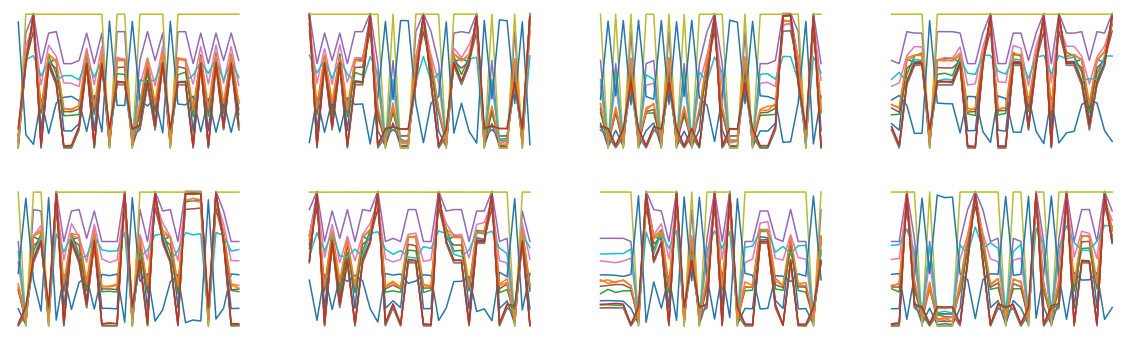

In [ ]:
real = train_FD[params["index"]-1][train_FD[params["index"]-1][0] == 32].to_numpy()
fig, ax = plt.subplots(2, 4, figsize=(20, 6))
for i in range(8):
    ax[i//4, i%4].plot(real[i*params["window_size"]:(i+1)*params["window_size"], 2:-1]) 
    ax[i//4, i%4].axis("off")
    #ax[i//4, i%4].set_title("%s" % real[(i+1)*params["window_size"]-1, -1])

### Train GAN
Here is the training of GAN model. During training, at each epoch, the MMD between real distribution and fake distribution is calculated. Additionally, visualization of generated data are provided (the top row shows fake data with the same condition to check mode collapse, the bottom shows fake data with different conditions). 

In [ ]:
import shutil
shutil.rmtree("./saved_models/")

In [ ]:
cacG, lonD, cuH = train_gan(trainloader=trainloader, device=device, params=params)

At this step, we pick the generator version that has the lowest MMD (highest -log(MMD)). Note that sometimes visual inspection can be used to choose the best generator.

Best generator at epoch 116


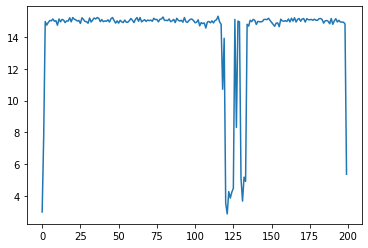

In [ ]:
print("Best generator at epoch %s" % (np.argmax(cuH["mmd"])+1))
plt.plot(cuH["mmd"])

### Train RUL

In [ ]:
# Declare hyperparameters for RUL prediction model.
rul_params = {
    # Data hyperparameters:
    "index": 3, 
    "valid_size": 0.1,
    "batch_size": 256,
    "window_size": 30,
    "max_rul": 130,
    "trim": True,

    # Model hyperparameters:
    "noise_size": 63,
    "feature_size": 14,
    "hidden_size": 256,
    "num_layers": 1,
    "dropout": 0.5,
    "bidirectional": False,

    # Training hypeparameters:
    "max_epochs": 200,
    "lr": 1e-3,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 5,
    "log_train_val": 50,
    "earlystop_patience": 20
}

In [ ]:
# Recreate the train/valid dataset/dataloader:
trainset, trainloader = prepare_data(train_fd, 
                                         params["window_size"], 
                                         1,
                                         params["max_rul"], 
                                         params["batch_size"], 
                                         params["trim"],
                                         True, 
                                         pin_memory=True)
validset, validloader = prepare_data(val_fd, 
                                         params["window_size"], 
                                         1,
                                         params["max_rul"], 
                                         params["batch_size"], 
                                         params["trim"],
                                         False, 
                                         pin_memory=True)

In [ ]:
# Prepare generator as well as a fake dataset and fake dataloader:
G = Generator(noise_size=params["noise_size"],
              hidden_size=params["hidden_size"],
              output_size=params["feature_size"],
              num_layers=params["num_layers"],
              dropout=params["dropout"])
G.load_state_dict(torch.load("/content/saved_models/G_index_3_epoch_179_noise_63_hidden_128_feature_14_layer_1_drop_50_window_30.pth", map_location="cpu"))
G = G.to(device).eval()
faketrainset = FakeDataset(n_fake=100000)
faketrainloader = DataLoader(faketrainset, rul_params["batch_size"], num_workers=cpu_count(), pin_memory=True)

#### GAN Augmentation 
Perform experiment to access the efficiency of GAN augmentation. Here 3 training schemes are conducted for comparison:

*   Train on real, test on real
*   Train on both real and fake, test on real
*   Train on fake, test on real
Each training scheme is conducted 16 times, then the best results of each time are used to get their mean and standard deviation.



In [ ]:
import shutil, glob
from statistics import mean, stdev

bm = {"real": [],
          "both": [],
          "fake": []}
for i in range(16):
    print("Pass %s" % (i))
    if os.path.exists("./saved_models/"):
        shutil.rmtree("./saved_models/")
    model, history = train_rul(mode="real", trainloader=trainloader, validloader=validloader, device=device, params=rul_params)
    model, history = train_rul(mode="both", trainloader=trainloader, validloader=validloader, params=rul_params, device=device, generator=G)
    model, history = train_rul(mode="fake", trainloader=trainloader, validloader=validloader, device=device, params=rul_params, generator=G)
    for f in glob.glob("./saved_models/*/*"):
        if "real" in f:
            model.load_state_dict(torch.load(f))
            tested = test(model, test_FD, rul_FD, rul_params["window_size"], rul_params["max_rul"], device)
            bm["real"].append(tested[rul_params["index"]-1])
            
        elif "both" in f:
            model.load_state_dict(torch.load(f))
            tested = test(model, test_FD, rul_FD, rul_params["window_size"], rul_params["max_rul"], device)
            bm["both"].append(tested[rul_params["index"]-1])
            
        elif "fake" in f:
            model.load_state_dict(torch.load(f))
            tested = test(model, test_FD, rul_FD, rul_params["window_size"], rul_params["max_rul"], device)
            bm["fake"].append(tested[rul_params["index"]-1])
            

print("Train on real, test on real:\tmean: %.4f\tstd: %.4f" % (mean(bm["real"]), stdev(bm["real"])))
print("Train on both, test on real:\tmean: %.4f\tstd: %.4f" % (mean(bm["both"]), stdev(bm["both"])))
print("Train on fake, test on real:\tmean: %.4f\tstd: %.4f" % (mean(bm["fake"]), stdev(bm["fake"])))

Pass 0
Pass 1
Pass 2
Pass 3
Pass 4
Pass 5
Pass 6
Pass 7
Pass 8
Pass 9
Pass 10
Pass 11
Pass 12
Pass 13
Pass 14
Pass 15
Train on real, test on real:	mean: 15.1958	std: 0.4369
Train on both, test on real:	mean: 15.2509	std: 0.3657
Train on fake, test on real:	mean: 16.7399	std: 0.4697
